In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal
import os
import inspect

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import Spectrogram
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

In [4]:
fft_size = 1024
avg_freq_axis = 8
avg_time_axis = 2

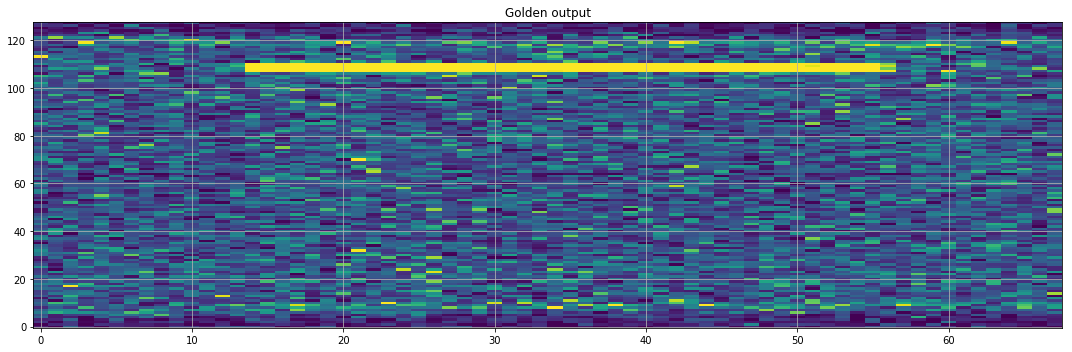

In [5]:
from pyha.cores import BitreversalFFTshiftAVGPool
file = os.path.dirname(inspect.getfile(BitreversalFFTshiftAVGPool)) + '/phantom3_low_power_bladerf.npy'
orig_inp = np.load(file) # IQ samples
orig_inp = orig_inp[:int(len(orig_inp)/fft_size)*fft_size]

golden_output = Spectrogram(fft_size, avg_freq_axis, avg_time_axis).model_main(orig_inp)

plt.title('Golden output')
imshow(golden_output.T)

# DC Removal

In [6]:
# NBVAL_IGNORE_OUTPUT
from pyha.cores import DCRemoval
dut = DCRemoval(256, dtype=Complex)
sims0 = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [00:11<00:00, 12144.51it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [7]:
snr(sims0['MODEL'], sims0['PYHA'])

47.246002489879956

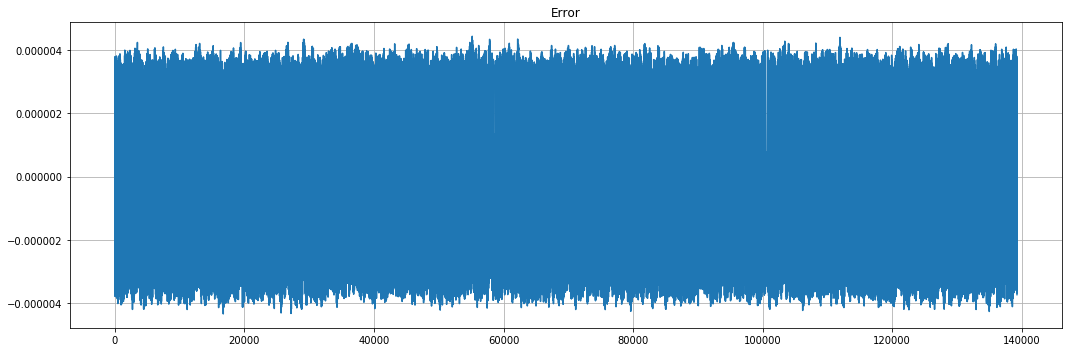

In [8]:
plt.title('Error')
plt.plot(sims0['MODEL'] - sims0['PYHA'])
show_plot()

# Packager

In [9]:
from pyha.cores import Packager
dut = Packager(fft_size)
sims1 = simulate(dut, sims0['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [00:04<00:00, 29244.20it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


In [10]:
snr(sims1['MODEL'], sims1['PYHA'])

inf

# Windower

In [11]:
from pyha.cores import Windower
dut = Windower(fft_size, coefficient_bits=8)
sims2 = simulate(dut, sims1['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [00:06<00:00, 23034.45it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


In [12]:
snr(sims2['MODEL'], sims2['PYHA'])

40.412894654330415

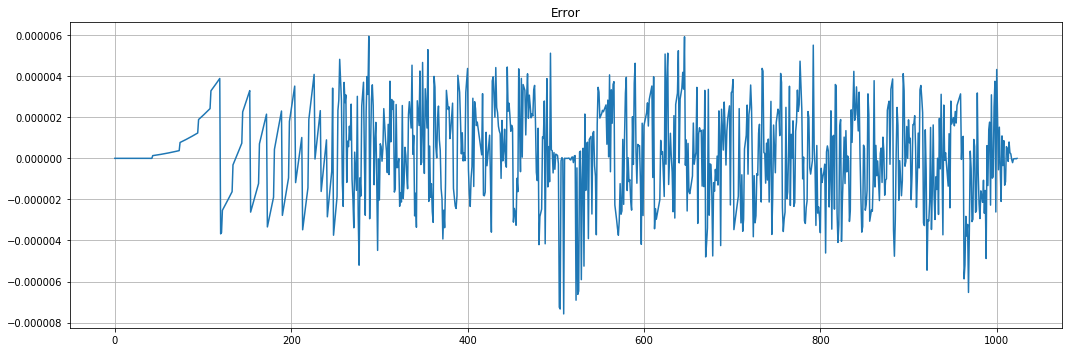

In [13]:
plt.title('Error')
plt.plot(sims2['MODEL'][0] - sims2['PYHA'][0])
show_plot()

# FFT

In [14]:
from pyha.cores import R2SDF
dut = R2SDF(fft_size, twiddle_bits=9)
sims3 = simulate(dut, sims2['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [01:11<00:00, 1958.51it/s]


INFO:sim:OK!
INFO:sim:Simulations completed!


In [15]:
snr(sims3['MODEL'], sims3['PYHA'])

8.962636500661409

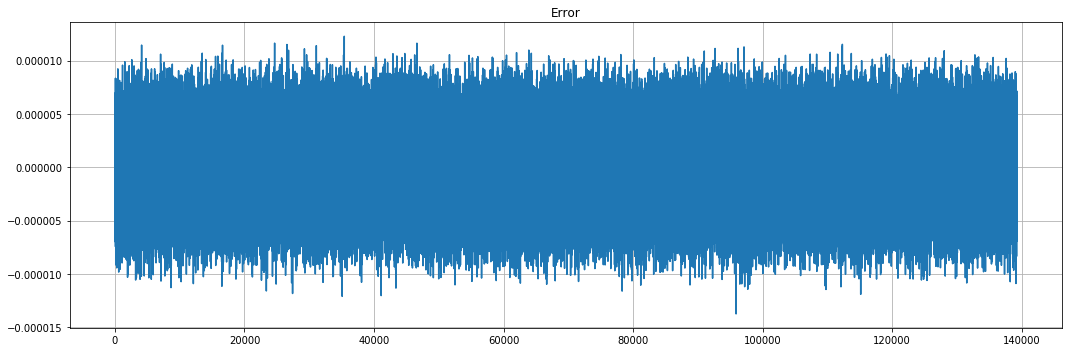

In [16]:
plt.title('Error')
plt.plot(sims3['MODEL'].flatten() - sims3['PYHA'].flatten())
show_plot()

# FFT to power

In [17]:
from pyha.cores import FFTPower
dut = FFTPower()
sims4 = simulate(dut, sims3['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [00:05<00:00, 24521.02it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [18]:
snr(sims4['MODEL'], sims4['PYHA'])

inf

# Bitrverse, FFTShift, AVGPool

In [19]:
from pyha.cores import BitreversalFFTshiftAVGPool
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis, avg_time_axis)
sims5 = simulate(dut, sims4['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139264/139264 [00:04<00:00, 34103.44it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [20]:
snr(golden_output, sims5['PYHA'])

19.26661286232874

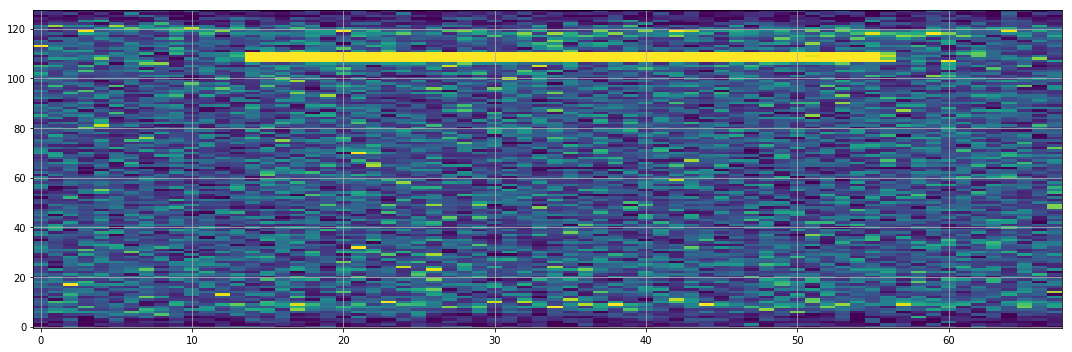

In [21]:
imshow(golden_output.T)

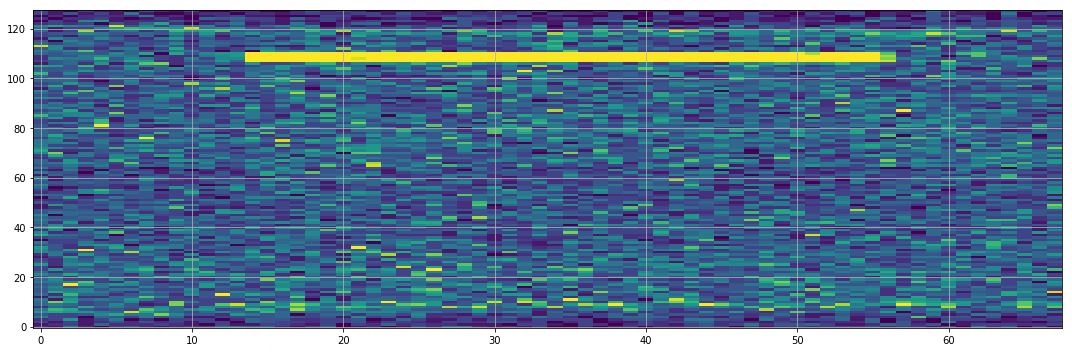

In [22]:
imshow(sims5['PYHA'].T)

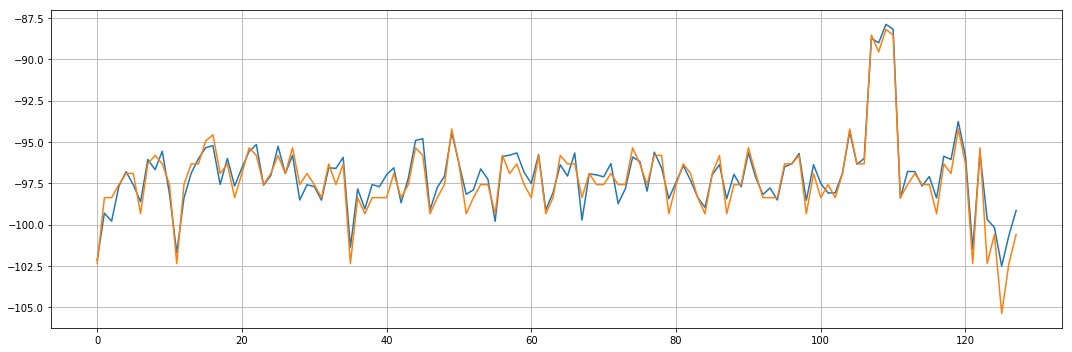

In [23]:
plt.plot(np.log10(golden_output[40])*10)
plt.plot(np.log10(sims5['PYHA'][40])*10)
show_plot()

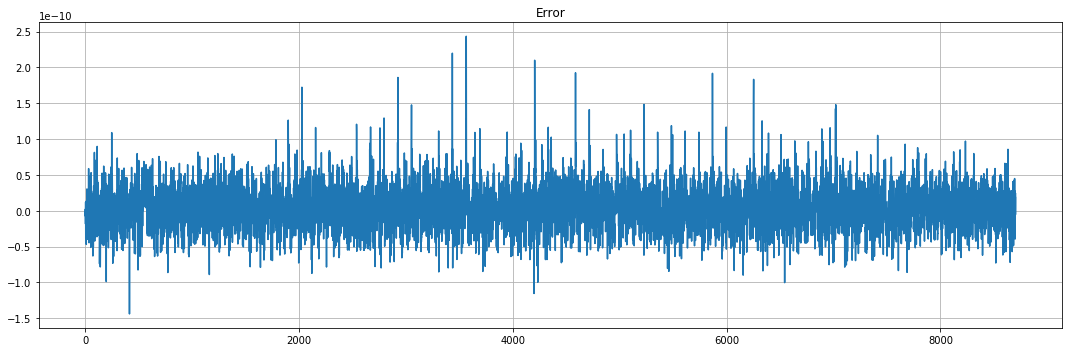

In [24]:
plt.title('Error')
plt.plot(golden_output.flatten() - sims5['PYHA'].flatten())
show_plot()